In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import h5py
import re
from collections import defaultdict
from tqdm.auto import tqdm
from markovids import pcl, vid, depth
from qd_analysis.fig import setup_plotting_env
from qd_analysis.util import load_example_frames

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
segmentation_dir = "_segmentation_tau-0-pretrain"

## User functions

In [5]:
def get_mouse_roi(
    fluo_frame,
    reflect_frame,
    mask,
    bbox_width=250,
    bbox_height=250,
    buffer=150,
    threshold=5,
    hist_equalization=True,
    mask_only=False,
    clahe=None,
):
    if hist_equalization and (clahe is None):
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    h, w = fluo_frame.shape
    if not mask_only:
        yy, xx = np.where((fluo_frame * mask) > threshold)
    else:
        yy, xx = np.where(mask > 0)
    try:
        corner = (max(min(xx) - buffer // 2, 0), max(min(yy) - buffer // 2, 0))
    except ValueError:
        return None, None
    bbox = (
        (max(corner[0], 0), min(corner[0] + bbox_width + 2 * buffer // 2, w - 1)),
        (max(corner[1], 0), min(corner[1] + bbox_height + 2 * buffer // 2, h - 1)),
    )
    plt_fluo = fluo_frame[range(*bbox[1])][:, range(*bbox[0])]
    if hist_equalization:
        plt_reflect = clahe.apply(reflect_frame[range(*bbox[1])][:, range(*bbox[0])])
        # plt_reflect = cv2.equalizeHist(reflect_frame[range(*bbox[1])][:, range(*bbox[0])])
    else:
        plt_reflect = reflect_frame[range(*bbox[1])][:, range(*bbox[0])]
    return plt_fluo, plt_reflect

In [ ]:
config = toml.load("../preprocessing/config.toml")
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [7]:
root_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/"

In [8]:
base_dir = os.path.join(root_dir, "timecourse_01")
fluo_files = sorted(glob.glob(os.path.join(base_dir, "**", "Basler*fluorescence.avi"), recursive=True))
base_dir = os.path.join(root_dir, "timecourse_01_agarose_beads")
fluo_files += sorted(glob.glob(os.path.join(base_dir, "**", "Basler*fluorescence.avi"), recursive=True))

In [9]:
base_dir_v2 = os.path.join(root_dir, "timecourse_02")
fluo_files_v2 = sorted(glob.glob(os.path.join(base_dir_v2, "**", "Basler*fluorescence.avi"), recursive=True))
base_dir_v2 = os.path.join(root_dir, "timecourse_02_joints")
fluo_files_v2 += sorted(glob.glob(os.path.join(base_dir_v2, "**", "Basler*fluorescence.avi"), recursive=True))

In [10]:
include_keywords = ["exp","ep","beads","vasc","vehicle","conj","blank","light_test"]
# include_keywords = ["beads", "exp", "ep", "vehicle"]
# include_keywords = ["beads"]

In [11]:
calibration_data = toml.load(os.path.join(root_dir, "timecourse_01_calibration.toml"))
calibration_data_v2 = toml.load(os.path.join(root_dir, "timecourse_02_calibration_v2.toml"))


In [12]:
# load background, subtract off from frame we want to use
# TODO REFLECTANCE!!!

In [13]:
# get subject names and filter that stuff...
metadata = {}
dirs = sorted(list(set([os.path.dirname(_) for _ in fluo_files])))
for _dir in tqdm(dirs):
    metadata[_dir] = toml.load(os.path.join(_dir, "../metadata.toml"))

  0%|          | 0/156 [00:00<?, ?it/s]

In [14]:
# get subject names and filter that stuff...
metadata_v2 = {}
dirs = sorted(list(set([os.path.dirname(_) for _ in fluo_files_v2])))
for _dir in tqdm(dirs):
    metadata_v2[_dir] = toml.load(os.path.join(_dir, "../metadata.toml"))

  0%|          | 0/43 [00:00<?, ?it/s]

In [15]:
keep_dirs_qd_exp = sorted([
    _file
    for _file in metadata.keys()
    if "qd_exp_01" in metadata[_file]["user_input"]["subject"].lower()
])

In [16]:
keep_dirs_vehicle = sorted([
    _file
    for _file in metadata.keys()
    if "vehicle" in metadata[_file]["user_input"]["subject"].lower()
])

In [17]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [18]:
load_dct = {}
for _cam in cameras:
    load_dct[_cam] = {}
    load_dct[_cam]["intrinsic_matrix"] = np.array(calibration_data["intrinsics"][_cam])
    load_dct[_cam]["distortion_coeffs"] = np.array(calibration_data["distortion_coeffs"][_cam] )

In [19]:
load_dct_v2 = {}
for _cam in cameras:
    load_dct_v2[_cam] = {}
    load_dct_v2[_cam]["intrinsic_matrix"] = np.array(calibration_data_v2["intrinsics"][_cam])
    load_dct_v2[_cam]["distortion_coeffs"] = np.array(calibration_data_v2["distortion_coeffs"][_cam] )

# Fig S3 filmstrip

In [ ]:
fluo_frames = {}
fluo_bgrounds = {}
fluo_frames_raw = {}
reflect_frames = {}
masks = {}
timestamps ={}

In [ ]:
use_dir = keep_dirs_qd_exp[0]
use_metadata = toml.load(os.path.join(use_dir, "..", "metadata.toml"))
cameras = list(use_metadata["camera_metadata"].keys())

In [ ]:
load_cameras = cameras

In [ ]:
# get a blank and a high intensity animal...
(
    fluo_frames["cell_labeling"],
    reflect_frames["cell_labeling"],
    masks["cell_labeling"],
    timestamps["cell_labeling"],
    fluo_bgrounds["cell_labeling"],
) = load_example_frames(use_dir, frame_range=range(0,300), load_cameras=load_cameras, load_dct=load_dct) # 0 looks pretty good...


In [ ]:
(
    fluo_frames_raw["cell_labeling"],
    _,
    _,
    _,
    _,
) = load_example_frames(keep_dirs_qd_exp[0], frame_range=range(0,300), bground_subtract_fluorescence=False, load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

In [ ]:
# get relevant background...

In [ ]:
ts_paths = {os.path.join(use_dir, "..", f"{_cam}.txt"): _cam for _cam in cameras}

In [ ]:
ts, use_merged_ts = vid.io.read_timestamps_multicam(ts_paths, merge_tolerance=0.001)
use_merged_ts = use_merged_ts.dropna()
ts_fluo = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 0
]  # fluorescence is 0,2,4,etc..
ts_reflect = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 1
]  # reflectance is 1,3,5,...

ts_idx = ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=1)
ts_include = np.flatnonzero(ts_idx >= 0)  # -1 if we don't get a match
ts_fluo = ts_fluo.iloc[ts_include]
ts_reflect = ts_reflect.iloc[
    ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=1)
]

In [ ]:
reflect_kwargs = {"vmin": 0, "vmax": 155, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 75, "cmap": "inferno"}
fluo_raw_kwargs = {"vmin": 0, "vmax": 125, "cmap": "inferno"}
plt_frames = np.arange(100,120,5)

In [ ]:
np.median(ts_fluo["system_timestamp"].values - ts_reflect["system_timestamp"].values)

In [ ]:
ts_reflect.loc[use_timestamps+1, "system_timestamp"].values - ts_fluo.loc[use_timestamps, "system_timestamp"].values

In [ ]:
use_timestamps = timestamps["cell_labeling"]["frame_id"].copy()
# use_timestamps -= use_timestamps.iloc[0]
use_timestamps = use_timestamps.iloc[plt_frames]

# use reflect, which is offset by +1

plt_timestamps = ts_reflect.loc[use_timestamps+1,"system_timestamp"]
plt_timestamps -= plt_timestamps.iloc[0]
fluo_offset = .005 + .001 + .0115 # assume we're mid-exposure, account for rest of exposure, low time and fluo
plt_timestamps = plt_timestamps.round(4)

In [ ]:
use_cam = load_cameras[0]
use_bground = 0
use_frame = 0
use_condition = "cell_labeling"

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(5, 2))
ax[0].imshow(fluo_frames_raw[use_condition][use_cam][use_frame], **fluo_kwargs)
ax[1].imshow(fluo_bgrounds[use_condition][use_cam]["bground"][use_bground], **fluo_kwargs)
h1 = ax[2].imshow(fluo_frames[use_condition][use_cam][use_frame], **fluo_kwargs)
titles = ["raw", "bground", "subtracted"]
for _ax, _title in zip(ax, titles):
    _ax.axis("off")
    _ax.set_title(_title, fontsize=7)

fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.35, aspect=10, pad=.01)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
cbar1.ax.tick_params(labelsize=5)
fig.savefig(os.path.join(fig_dir, "still_images_bground_sub_example.pdf"), bbox_inches="tight", dpi=600)

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(reflect_frames[use_condition][_camera][_frame], **reflect_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_cell_labeling_0h_filmstrip_reflect.pdf"), bbox_inches="tight", dpi=600)

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(fluo_frames[use_condition][_camera][_frame], **fluo_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps + fluo_offset):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_cell_labeling_0h_filmstrip_fluo.pdf"), bbox_inches="tight", dpi=600)

# Fig S4 filmstrip

In [ ]:
keep_dirs_qd_exp = sorted([
    _file
    for _file in metadata.keys()
    if "qd_exp_03" in metadata[_file]["user_input"]["subject"].lower()
])

In [ ]:
fluo_frames = {}
fluo_frames_raw = {}
reflect_frames = {}
masks = {}
timestamps ={}

In [ ]:
use_dir = keep_dirs_qd_exp[1]
use_metadata = toml.load(os.path.join(use_dir, "..", "metadata.toml"))
cameras = list(use_metadata["camera_metadata"].keys())

In [ ]:
use_dir

In [ ]:
load_cameras = cameras

In [ ]:
# get a blank and a high intensity animal...
(
    fluo_frames["cell_labeling"],
    reflect_frames["cell_labeling"],
    masks["cell_labeling"],
    timestamps["cell_labeling"],
    _,
) = load_example_frames(use_dir, frame_range=range(200, 700), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

# (
#     fluo_frames["vehicle"],
#     reflect_frames["vehicle"],
#     masks["vehicle"],
#     timestamps["vehicle"],
# ) = load_example_frames(keep_dirs_vehicle[0], frame_range=range(0,300), load_dct=load_dct, load_cameras=load_cameras)

In [ ]:
# get relevant background...

In [ ]:
ts_paths = {os.path.join(use_dir, "..", f"{_cam}.txt"): _cam for _cam in cameras}

In [ ]:
ts, use_merged_ts = vid.io.read_timestamps_multicam(ts_paths, merge_tolerance=0.001)
use_merged_ts = use_merged_ts.dropna()
ts_fluo = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 0
]  # fluorescence is 0,2,4,etc..
ts_reflect = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 1
]  # reflectance is 1,3,5,...

ts_idx = ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=2)
ts_include = np.flatnonzero(ts_idx >= 0)  # -1 if we don't get a match
ts_fluo = ts_fluo.iloc[ts_include]
ts_reflect = ts_reflect.iloc[
    ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=2)
]

In [ ]:
reflect_kwargs = {"vmin": 0, "vmax": 155, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 75, "cmap": "inferno"}
fluo_raw_kwargs = {"vmin": 0, "vmax": 125, "cmap": "inferno"}
plt_frames = np.arange(100, 140, 10)

In [ ]:
use_timestamps = timestamps["cell_labeling"]["frame_id"].copy()
# use_timestamps -= use_timestamps.iloc[0]
use_timestamps = use_timestamps.iloc[plt_frames]

plt_timestamps = ts_fluo.loc[use_timestamps,"system_timestamp"]
plt_timestamps -= plt_timestamps.iloc[0]

plt_timestamps = plt_timestamps.round(4)

In [ ]:
# show processing pipeline using an example frame and bground subtract...

In [ ]:
use_cam = load_cameras[0]
use_bground = 0
use_frame = 0
use_condition = "cell_labeling"

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(reflect_frames[use_condition][_camera][_frame], **reflect_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_cell_labeling_0h_filmstrip_reflect_02.pdf"), bbox_inches="tight", dpi=600)

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(fluo_frames[use_condition][_camera][_frame], **fluo_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps + fluo_offset):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_cell_labeling_0h_filmstrip_fluo_02.pdf"), bbox_inches="tight", dpi=600)

# Fig S7 filmstrip

In [ ]:
keep_dirs_qd_exp = sorted([
    _file
    for _file in metadata_v2.keys()
    if "qd_beads_09" in metadata_v2[_file]["user_input"]["subject"].lower()
])

In [ ]:
fluo_frames = {}
fluo_frames_raw = {}
reflect_frames = {}
masks = {}
timestamps ={}

In [ ]:
use_dir = keep_dirs_qd_exp[1]
use_metadata = toml.load(os.path.join(use_dir, "..", "metadata.toml"))
cameras = list(use_metadata["camera_metadata"].keys())

In [ ]:
use_dir

In [ ]:
load_cameras = cameras

In [ ]:
# get a blank and a high intensity animal...
(
    fluo_frames["beads_v2"],
    reflect_frames["beads_v2"],
    masks["beads_v2"],
    timestamps["beads_v2"],
    _,
) = load_example_frames(use_dir, frame_range=range(200, 700), load_dct=load_dct_v2, load_cameras=load_cameras) # 0 looks pretty good...

# (
#     fluo_frames["vehicle"],
#     reflect_frames["vehicle"],
#     masks["vehicle"],
#     timestamps["vehicle"],
# ) = load_example_frames(keep_dirs_vehicle[0], frame_range=range(0,300), load_dct=load_dct, load_cameras=load_cameras)

In [ ]:
# get relevant background...

In [ ]:
ts_paths = {os.path.join(use_dir, "..", f"{_cam}.txt"): _cam for _cam in cameras}

In [ ]:
ts, use_merged_ts = vid.io.read_timestamps_multicam(ts_paths, merge_tolerance=0.001)
use_merged_ts = use_merged_ts.dropna()
ts_fluo = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 0
]  # fluorescence is 0,2,4,etc..
ts_reflect = use_merged_ts.loc[
    np.mod(use_merged_ts.index, 2) == 1
]  # reflectance is 1,3,5,...

ts_idx = ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=2)
ts_include = np.flatnonzero(ts_idx >= 0)  # -1 if we don't get a match
ts_fluo = ts_fluo.iloc[ts_include]
ts_reflect = ts_reflect.iloc[
    ts_reflect.index.get_indexer(ts_fluo.index, method="nearest", tolerance=2)
]

In [ ]:
reflect_kwargs = {"vmin": 0, "vmax": 255, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 150, "cmap": "inferno"}
fluo_raw_kwargs = {"vmin": 0, "vmax": 125, "cmap": "inferno"}
plt_frames = np.arange(100, 140, 10)

In [ ]:
use_timestamps = timestamps["beads_v2"]["frame_id"].copy()
# use_timestamps -= use_timestamps.iloc[0]
use_timestamps = use_timestamps.iloc[plt_frames]

plt_timestamps = ts_fluo.loc[use_timestamps,"system_timestamp"]
plt_timestamps -= plt_timestamps.iloc[0]

plt_timestamps = plt_timestamps.round(4)

In [ ]:
# show processing pipeline using an example frame and bground subtract...

In [ ]:
use_cam = load_cameras[0]
use_bground = 0
use_frame = 0
use_condition = "beads_v2"

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
# use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(reflect_frames[use_condition][_camera][_frame], **reflect_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_beads_v2_0h_filmstrip_reflect.pdf"), bbox_inches="tight", dpi=600)

In [ ]:
fig, ax = plt.subplots(len(load_cameras), len(plt_frames), figsize=(1.5 * len(plt_frames), 1.5 * len(load_cameras)))
# ax = ax.T
use_cam = load_cameras[1]
# use_condition = "cell_labeling"
for _camera, rax in zip(load_cameras, ax):
    for _frame, _ax in zip(plt_frames, rax):
        h1 = _ax.imshow(fluo_frames[use_condition][_camera][_frame], **fluo_kwargs)
        # h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
for _ax, _timestamp in zip(ax[0], plt_timestamps + fluo_offset):
    _ax.set_title(f"{_timestamp:.04f} seconds", fontsize=5)
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.15, aspect=10, pad=.01)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
# fig.tight_layout()

# cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
# cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, "still_images_beads_v2_0h_filmstrip_fluo.pdf"), bbox_inches="tight", dpi=600)

# Fig 1 (day 0 stills, fluo only)

In [36]:
scale_bar_pxs = 50

In [20]:
fluo_frames = {}
reflect_frames = {}
masks = {}
timestamps ={}

In [21]:
load_cameras = [cameras[0], cameras[1], cameras[2]]

In [22]:
# get a blank and a high intensity animal...
(
    fluo_frames["cell_labeling"],
    reflect_frames["cell_labeling"],
    masks["cell_labeling"],
    timestamps["cell_labeling"],
    _,
) = load_example_frames(keep_dirs_qd_exp[0], frame_range=range(2000,2300), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...
(
    fluo_frames["vehicle"],
    reflect_frames["vehicle"],
    masks["vehicle"],
    timestamps["vehicle"],
    _,
) = load_example_frames(keep_dirs_vehicle[0], frame_range=range(2000,2300), load_dct=load_dct, load_cameras=load_cameras)

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [23]:
import cmocean

In [24]:
setup_plotting_env()

In [25]:
bbox_width = 250
bbox_height = 150
buffer = 100
reflect_kwargs = {"vmin": 0, "vmax": 150, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 75, "cmap": "inferno"}
use_frame = {"cell_labeling": 225, "vehicle": 102} # 100 good for cell labeling
threshold = 10

In [26]:
plt_fluo = {}
plt_reflect = {}
clahe = cv2.createCLAHE(clipLimit=1., tileGridSize=(32, 32))
for _condition in fluo_frames.keys():
    plt_fluo[_condition] = {}
    plt_reflect[_condition] = {}
    for _cam in load_cameras:
        plt_fluo[_condition][_cam], plt_reflect[_condition][_cam] = get_mouse_roi(
            fluo_frames[_condition][_cam][use_frame[_condition]],
            reflect_frames[_condition][_cam][use_frame[_condition]],
            masks[_condition][_cam][use_frame[_condition]],
            bbox_width=bbox_width,
            bbox_height=bbox_height,
            buffer=buffer,
            threshold=threshold,
            hist_equalization=False,
            clahe=clahe,
        )

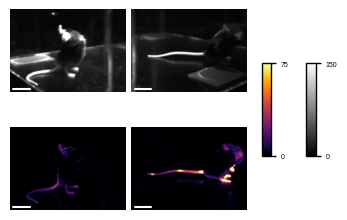

In [39]:
# ADD SCALE BAR TO IMAGES...
fig, ax = plt.subplots(2, 2, figsize=(4.5,3.))
ax = ax.T
use_cam = load_cameras[1]
for _condition, _ax in zip(["vehicle", "cell_labeling"], ax):
    h1 = _ax[0].imshow(plt_reflect[_condition][use_cam], **reflect_kwargs)
    h, w = plt_reflect[_condition][use_cam].shape
    _ax[0].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
    h2 = _ax[1].imshow(plt_fluo[_condition][use_cam], **fluo_kwargs)
    _ax[1].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.tight_layout()
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=0.)
cbar1.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
cbar2 = fig.colorbar(h2, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=.05)
cbar2.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"still_images_vehicle_v_cell_labeling_0h_scale_bar-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)

# Fig. 2 example, cell labeling vs vascular labels, +2-3 days

In [40]:
import re

In [41]:
# get subject names and filter that stuff...
metadata = {}
dirs = sorted(list(set([os.path.dirname(_) for _ in fluo_files])))
for _dir in tqdm(dirs):
    metadata[_dir] = toml.load(os.path.join(_dir, "../metadata.toml"))

  0%|          | 0/156 [00:00<?, ?it/s]

In [42]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [43]:
from collections import defaultdict

In [44]:
keep_dirs_qd_exp = defaultdict(dict)
keep_dirs_vasc_exp = defaultdict(dict)
for k, _metadata in metadata.items():
    try:
        hours_from_injection = int(re.search("(\d+)h", _metadata["user_input"]["notes"]).groups(0)[0])
    except AttributeError:
        hours_from_injection = np.inf


    subject = _metadata["user_input"]["subject"].lower()
    
    if ("qd_exp" not in subject) and ("vasc" not in subject):
        continue
    
    if "qd_exp" in subject:
        keep_dirs_qd_exp[subject][hours_from_injection] = k
    else:
        keep_dirs_vasc_exp[subject][hours_from_injection] = k


In [45]:
keep_dirs_qd_exp["qd_exp_01"][1]

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/timecourse_01/session_20231204114743-438357 (system76-pc)/_proc'

In [46]:
fluo_frames_2 = defaultdict(dict)
reflect_frames_2 = defaultdict(dict)
masks_2 = defaultdict(dict)
timestamps_2 = defaultdict(dict)

In [47]:
load_hours = [1, 24, 48]
load_cameras = [cameras[1]]

In [48]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_2["cell_labeling"][_hour],
        reflect_frames_2["cell_labeling"][_hour],
        masks_2["cell_labeling"][_hour],
        _,
        _,
        # timestamps["cell_labeling"],
    ) = load_example_frames(keep_dirs_qd_exp["qd_exp_01"][_hour], frame_range=range(2000,2500), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [49]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_2["vascular"][_hour],
        reflect_frames_2["vascular"][_hour],
        masks_2["vascular"][_hour],
        _,
        _,
        # timestamps["cell_labeling"],
    ) = load_example_frames(keep_dirs_vasc_exp["qd_vasc_02"][_hour], frame_range=range(2000,2500), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [50]:
bbox_width = 250
bbox_height = 150
buffer = 150
reflect_kwargs = {"vmin": 0, "vmax": 200, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 75, "cmap": "inferno"}
use_frame = {"cell_labeling": {1: 20, 24: 1, 48: 20}, "vascular": {1: 150, 24: 100, 48: 9}}
threshold = 5

In [51]:
plt_fluo = defaultdict(dict)
plt_reflect = defaultdict(dict)

for _condition in fluo_frames_2.keys():
    # plt_fluo[_condition] = {}
    # plt_reflect[_condition] = {}
    plt_fluo[_condition] = defaultdict(dict)
    plt_reflect[_condition] = defaultdict(dict)
        
    for _cam in load_cameras:
        for _hour in load_hours:
            fluo_frame = fluo_frames_2[_condition][_hour][_cam][use_frame[_condition][_hour]]
            mask = masks_2[_condition][_hour][_cam][use_frame[_condition][_hour]].astype("uint8")
            reflect_frame = reflect_frames_2[_condition][_hour][_cam][use_frame[_condition][_hour]]
            plt_fluo[_condition][_hour][_cam], plt_reflect[_condition][_hour][_cam] = get_mouse_roi(
                fluo_frame,
                reflect_frame,
                mask,
                bbox_width=bbox_width,
                bbox_height=bbox_height,
                buffer=buffer,
                threshold=threshold,
            )

In [52]:
# show progression over 48 hours...

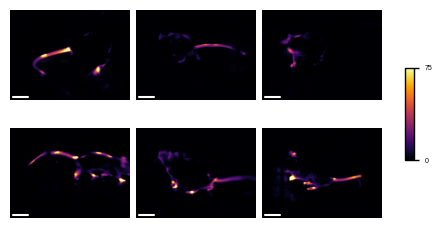

In [55]:
fig, ax = plt.subplots(2, len(load_hours), figsize=(6,3.))
# ax = ax.T

for _condition, rax in zip(["vascular", "cell_labeling"], ax):
    for _hour, _ax in zip(load_hours, rax):
        h1 = _ax.imshow(plt_fluo[_condition][_hour][use_cam], **fluo_kwargs)
        h, w = plt_fluo[_condition][_hour][use_cam].shape
        _ax.plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
    
        
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
# # fig.tight_layout()
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=0.05)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"still_images_vascular_v_cell_labeling_0h-24h-48h_scale_bar-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)

# Fig 3 example, cell labeling vs agarose beads, +7 days

In [56]:
import re

In [57]:
# get subject names and filter that stuff...
metadata = {}
dirs = sorted(list(set([os.path.dirname(_) for _ in fluo_files])))
for _dir in tqdm(dirs):
    metadata[_dir] = toml.load(os.path.join(_dir, "../metadata.toml"))

  0%|          | 0/156 [00:00<?, ?it/s]

In [58]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [59]:
from collections import defaultdict

In [60]:
keep_dirs_qd_exp = defaultdict(dict)
keep_dirs_beads_exp = defaultdict(dict)
keep_dirs_vasc_exp = defaultdict(dict)
for k, _metadata in metadata.items():
    try:
        hours_from_injection = int(re.search("(\d+)h", _metadata["user_input"]["notes"]).groups(0)[0])
    except AttributeError:
        hours_from_injection = np.inf


    subject = _metadata["user_input"]["subject"].lower()
    
    if ("qd_exp" not in subject) and ("qd_beads" not in subject) and ("vasc" not in subject):
        continue
    
    if "qd_exp" in subject:
        keep_dirs_qd_exp[subject][hours_from_injection] = k
    elif "beads" in subject:
        keep_dirs_beads_exp[subject][hours_from_injection] = k
    else:
        keep_dirs_vasc_exp[subject][hours_from_injection] = k

In [61]:
load_hours = [1, 48, 96]
load_cameras = [cameras[1]]

In [62]:
fluo_frames_3 = defaultdict(dict)
reflect_frames_3 = defaultdict(dict)
masks_3 = defaultdict(dict)
timestamps_3 = defaultdict(dict)

In [63]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_3["cell_labeling"][_hour],
        reflect_frames_3["cell_labeling"][_hour],
        masks_3["cell_labeling"][_hour],
        _,
        _,
        # timestamps["cell_labeling"],
    ) = load_example_frames(keep_dirs_qd_exp["qd_exp_01"][_hour], frame_range=range(2000,2500), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [64]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_3["beads"][_hour],
        reflect_frames_3["beads"][_hour],
        masks_3["beads"][_hour],
        _,
        _,
        # timestamps["cell_labeling"],
    ) = load_example_frames(keep_dirs_beads_exp["qd_beads_03"][_hour], frame_range=range(0,500), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [65]:
bbox_width = 250
bbox_height = 150
buffer = 150
reflect_kwargs = {"vmin": 0, "vmax": 200, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 75, "cmap": "inferno"}
use_frame = {"cell_labeling": {1: 20, 48: 20, 96: 450}, "beads": {1: 80, 48: 400, 96: 270}}
threshold = 5

In [66]:
plt_fluo = defaultdict(dict)
plt_reflect = defaultdict(dict)

for _condition in fluo_frames_3.keys():
    # plt_fluo[_condition] = {}
    # plt_reflect[_condition] = {}
    plt_fluo[_condition] = defaultdict(dict)
    plt_reflect[_condition] = defaultdict(dict)
        
    for _cam in load_cameras:
        for _hour in load_hours:
            fluo_frame = fluo_frames_3[_condition][_hour][_cam][use_frame[_condition][_hour]]
            mask = masks_3[_condition][_hour][_cam][use_frame[_condition][_hour]].astype("uint8")
            reflect_frame = reflect_frames_3[_condition][_hour][_cam][use_frame[_condition][_hour]]
            plt_fluo[_condition][_hour][_cam], plt_reflect[_condition][_hour][_cam] = get_mouse_roi(
                fluo_frame,
                reflect_frame,
                mask,
                bbox_width=bbox_width,
                bbox_height=bbox_height,
                buffer=buffer,
                threshold=threshold,
            )

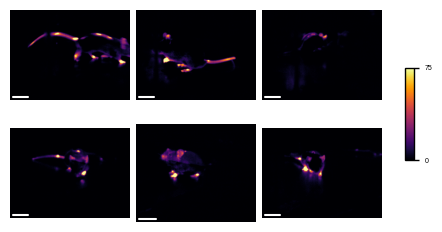

In [67]:
fig, ax = plt.subplots(2, len(load_hours), figsize=(6,3.))
# ax = ax.T

for _condition, rax in zip(["cell_labeling", "beads"], ax):
    for _hour, _ax in zip(load_hours, rax):
        h1 = _ax.imshow(plt_fluo[_condition][_hour][use_cam], **fluo_kwargs)
        h, w = plt_fluo[_condition][_hour][use_cam].shape
        _ax.plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")

        
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
# # fig.tight_layout()
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=0.05)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"still_images_cell_labeling_v_beads_0h-48h-96h-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)

# Fig 5 Beads v2

In [68]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [69]:
keep_dirs_beads_exp = defaultdict(dict)
keep_dirs_beads_v2_exp = defaultdict(dict)
for k, _metadata in metadata.items():
    try:
        hours_from_injection = int(re.search("(\d+)h", _metadata["user_input"]["notes"]).groups(0)[0])
    except AttributeError:
        hours_from_injection = np.inf
    subject = _metadata["user_input"]["subject"].lower()
    if "beads" in subject:
        keep_dirs_beads_exp[subject][hours_from_injection] = k
for k, _metadata in metadata_v2.items():
    try:
        hours_from_injection = int(re.search("(\d+)h", _metadata["user_input"]["notes"]).groups(0)[0])
    except AttributeError:
        hours_from_injection = np.inf
    subject = _metadata["user_input"]["subject"].lower()
    if "beads" in subject:
        keep_dirs_beads_v2_exp[subject][hours_from_injection] = k

In [70]:
load_hours = [24, 48, 96]
load_cameras = [cameras[1]]

In [71]:
fluo_frames_4 = defaultdict(dict)
reflect_frames_4 = defaultdict(dict)
masks_4 = defaultdict(dict)
timestamps_4 = defaultdict(dict)

In [72]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_4["beads"][_hour],
        reflect_frames_4["beads"][_hour],
        masks_4["beads"][_hour],
        _,
        _,
        # timestamps["beads"],
    ) = load_example_frames(keep_dirs_beads_exp["qd_beads_03"][_hour], frame_range=range(2000,2500), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [73]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_4["beads_v2"][_hour],
        reflect_frames_4["beads_v2"][_hour],
        masks_4["beads_v2"][_hour],
        _,
        _,
        # timestamps["cell_labeling"],
    ) = load_example_frames(keep_dirs_beads_v2_exp["qd_beads_07"][_hour], frame_range=range(0,500), load_dct=load_dct_v2, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [74]:
bbox_width = 250
bbox_height = 150
buffer = 150
reflect_kwargs = {"vmin": 0, "vmax": 200, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 150, "cmap": "inferno"}
use_frame = {"beads": {24: 20, 48: 20, 96: 450}, "beads_v2": {24: 80, 48: 200, 96: 100}}
threshold = 5

In [75]:
plt_fluo = defaultdict(dict)
plt_reflect = defaultdict(dict)

for _condition in fluo_frames_4.keys():
    # plt_fluo[_condition] = {}
    # plt_reflect[_condition] = {}
    plt_fluo[_condition] = defaultdict(dict)
    plt_reflect[_condition] = defaultdict(dict)
        
    for _cam in load_cameras:
        for _hour in load_hours:
            fluo_frame = fluo_frames_4[_condition][_hour][_cam][use_frame[_condition][_hour]]
            mask = masks_4[_condition][_hour][_cam][use_frame[_condition][_hour]].astype("uint8")
            reflect_frame = reflect_frames_4[_condition][_hour][_cam][use_frame[_condition][_hour]]
            plt_fluo[_condition][_hour][_cam], plt_reflect[_condition][_hour][_cam] = get_mouse_roi(
                fluo_frame,
                reflect_frame,
                mask,
                bbox_width=bbox_width,
                bbox_height=bbox_height,
                buffer=buffer,
                threshold=threshold,
            )

In [76]:
use_cam = cameras[1]

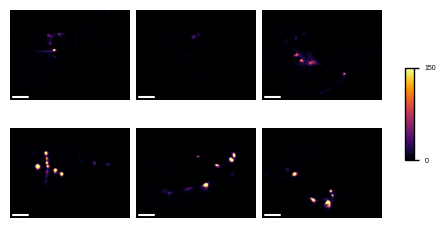

In [77]:
fig, ax = plt.subplots(2, len(load_hours), figsize=(6,3.))
# ax = ax.T

for _condition, rax in zip(["beads", "beads_v2"], ax):
    for _hour, _ax in zip(load_hours, rax):
        h1 = _ax.imshow(plt_fluo[_condition][_hour][use_cam], **fluo_kwargs)
        h, w = plt_fluo[_condition][_hour][use_cam].shape
        _ax.plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
        
for _ax in ax.ravel():
    _ax.axis("off")
fig.subplots_adjust(wspace=0.05, hspace=0.05)
# # fig.tight_layout()
cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=0.05)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"still_images_beads_vs_beads_v2_24h-48h-96h-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)

# Fig 6 Beads in knee joints

In [78]:
# NEED TO MODIFY ACCORDINGLY

In [79]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [80]:
keep_dirs_beads_knee = defaultdict(dict)
for k, _metadata in metadata_v2.items():
    try:
        hours_from_injection = int(re.search("(\d+)h", _metadata["user_input"]["notes"]).groups(0)[0])
    except AttributeError:
        hours_from_injection = np.inf
    subject = _metadata["user_input"]["subject"].lower()
    if "knee" in subject:
        keep_dirs_beads_knee[subject][hours_from_injection] = k

In [81]:
load_hours = [1]
load_cameras = cameras

In [82]:
fluo_frames_5 = defaultdict(dict)
reflect_frames_5 = defaultdict(dict)
masks_5 = defaultdict(dict)
timestamps_5 = defaultdict(dict)

In [83]:
keep_dirs_beads_knee["qd_knee_03"][1]

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/timecourse_02_joints/session_20240807185653-046788 (system76-pc)/_proc'

In [84]:
# get a blank and a high intensity animal...
for _hour in tqdm(load_hours):
    (
        fluo_frames_5["beads"][_hour],
        reflect_frames_5["beads"][_hour],
        masks_5["beads"][_hour],
        _,
        _,
        # timestamps["beads"],
    ) = load_example_frames(keep_dirs_beads_knee["qd_knee_03"][_hour], frame_range=range(4000,4800), load_dct=load_dct, load_cameras=load_cameras) # 0 looks pretty good...

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-PjW5/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [85]:
bbox_width = 250
bbox_height = 300
buffer = 200
reflect_kwargs = {"vmin": 0, "vmax": 255, "cmap": "gray"}
fluo_kwargs = {"vmin": 0, "vmax": 150, "cmap": "inferno"}
use_frame = {"beads": {1: 465, 48: 20, 96: 450}}
threshold = 0

In [86]:
plt_fluo = defaultdict(dict)
plt_reflect = defaultdict(dict)

for _condition in fluo_frames_5.keys():
    # plt_fluo[_condition] = {}
    # plt_reflect[_condition] = {}
    plt_fluo[_condition] = defaultdict(dict)
    plt_reflect[_condition] = defaultdict(dict)
        
    for _cam in load_cameras:
        for _hour in load_hours:
            fluo_frame = fluo_frames_5[_condition][_hour][_cam][use_frame[_condition][_hour]]
            mask = masks_5[_condition][_hour][_cam][use_frame[_condition][_hour]].astype("uint8")
            reflect_frame = reflect_frames_5[_condition][_hour][_cam][use_frame[_condition][_hour]]
            
            # MATCH ACROSS VIEWS????
            
            plt_fluo[_condition][_hour][_cam], plt_reflect[_condition][_hour][_cam] = get_mouse_roi(
                fluo_frame,
                reflect_frame,
                mask,
                bbox_width=bbox_width,
                bbox_height=bbox_height,
                buffer=buffer,
                threshold=threshold,
                mask_only=True,
                hist_equalization=False,
            )

In [87]:
# show fluo and reflectance in a short sequence...
use_hour = 1
show_cameras = cameras

In [88]:
setup_plotting_env()

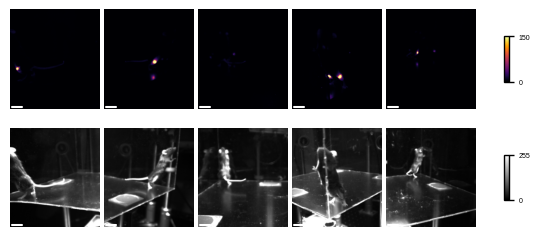

In [91]:
fig, ax = plt.subplots(2, len(show_cameras), figsize=(len(show_cameras)*1.5,3))

for i, _camera in enumerate(show_cameras):
    try:
        h1 = ax[0][i].imshow(plt_fluo["beads"][use_hour][_camera], **fluo_kwargs)
        h2 = ax[1][i].imshow(plt_reflect["beads"][use_hour][_camera], **reflect_kwargs)
        h, w = plt_fluo["beads"][_hour][use_cam].shape
        ax[0][i].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
        ax[1][i].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
    except TypeError:
        continue
    
for _ax in ax.ravel():
    _ax.axis("off")

fig.subplots_adjust(wspace=0.05, hspace=0.05)
# # fig.tight_layout()
cbar1 = fig.colorbar(h1, ax=list(ax[0].ravel()), shrink=.4, aspect=10, pad=0.05)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
cbar2 = fig.colorbar(h2, ax=list(ax[1].ravel()), shrink=.4, aspect=10, pad=0.05)
cbar2.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"kneejoints-1h-multiview-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)

In [92]:
seq = range(450,470,5)

In [93]:
plt_fluo = defaultdict(dict)
plt_reflect = defaultdict(dict)
use_condition = "beads"
use_camera = cameras[3]
use_hour = 1

# MATCH ACROSS VIEWS????
for i, _frame in enumerate(seq):
    
    fluo_frame = fluo_frames_5[use_condition][use_hour][use_camera][_frame]
    mask = masks_5[use_condition][use_hour][use_camera][_frame].astype("uint8")
    reflect_frame = reflect_frames_5[use_condition][use_hour][use_camera][_frame]

    plt_fluo[i], plt_reflect[i] = get_mouse_roi(
        fluo_frame,
        reflect_frame,
        mask,
        bbox_width=bbox_width,
        bbox_height=bbox_height,
        buffer=buffer,
        threshold=threshold,
        mask_only=True,
        hist_equalization=False,
    )

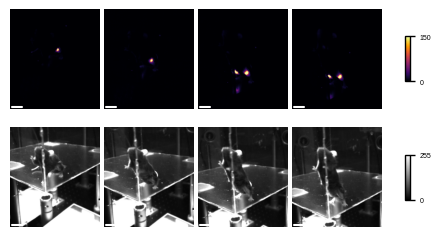

In [94]:
fig, ax = plt.subplots(2, len(seq), figsize=(len(seq)*1.5,3))

for i in range(len(seq)):
    try:
        h1 = ax[0][i].imshow(plt_fluo[i], **fluo_kwargs)
        h2 = ax[1][i].imshow(plt_reflect[i], **reflect_kwargs)
        h, w = plt_fluo[i].shape
        ax[0][i].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
        ax[1][i].plot([10, 10 + scale_bar_pxs],[ h - 10, h - 10], lw=1.5, color="w")
    except TypeError:
        continue
    
    

for _ax in ax.ravel():
    _ax.axis("off")

fig.subplots_adjust(wspace=0.05, hspace=0.05)
# # fig.tight_layout()
# cbar1 = fig.colorbar(h1, ax=list(ax.ravel()), shrink=.4, aspect=10, pad=0.05)
# cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])

cbar1 = fig.colorbar(h1, ax=list(ax[0].ravel()), shrink=.4, aspect=10, pad=0.05)
cbar1.set_ticks([fluo_kwargs["vmin"], fluo_kwargs["vmax"]])
cbar2 = fig.colorbar(h2, ax=list(ax[1].ravel()), shrink=.4, aspect=10, pad=0.05)
cbar2.set_ticks([reflect_kwargs["vmin"], reflect_kwargs["vmax"]])
fig.savefig(os.path.join(fig_dir, f"kneejoints-1h-sequence-camera3-{scale_bar_pxs}pxs.pdf"), bbox_inches="tight", dpi=600)